# Deliverys Center,  previsão de vendas!

Contexto: A deliverys center é uma plataforma onde lojistas podem registrar suas lojas para ter um cadastro online de vendas, após o registro seus pedidos e demadnas ficam integrados ao sitema logístico da deliverys center, que faz a entrega dos produtos.

O aprimoramento: Alguns lojistas gostariam de se antever a demanda que terão no próximo dia de vendas, para que possam planejar melhor os estoques e atendimentos, é possível que consigamos fazer uma IA que preveja as vendas do próximo dia melhor que uma média simples?

## Libs

In [1]:
# basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

## Functions

In [23]:
# join's
def join(df1, df2, key):
    df1 = df1.set_index(key).join(df2.set_index(key))
    df1 = df1.reset_index()
    df1 = df1.drop(key, axis=1)
    
    return df1

# week making
def day_making(df, col):
    
    # sort df
    df = df.sort_values(col)
    
    # def week col
    df['day'] = 0
    
    # def min date for reference
    min_date = df[col].min()
    
    # multiplier
    m = 1
    
    # for ever row in df
    for i in range(len(df[col])):
        # if the row "week" stil's 0 
        while df['day'].iloc[i] == 0:
            
            # check if it is less than min_date + (7 days * multiplier), if it is, define it as the multiplier intenger
            if df[col].iloc[i] <= min_date + pd.to_timedelta(1*m, unit='d'):
                df['day'].iloc[i] = m
                
            # if it is not less, then increase the multiplier, and run again
            else:
                m += 1
            
    return df

# clean infinite and Nan's (taked from stackoverflow)
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

# generate lag days
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1, 30):
        col = 'lag_' + str(i)
        supervised_df[col] = supervised_df['sales'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index()
    
    return supervised_df

## Joining Data

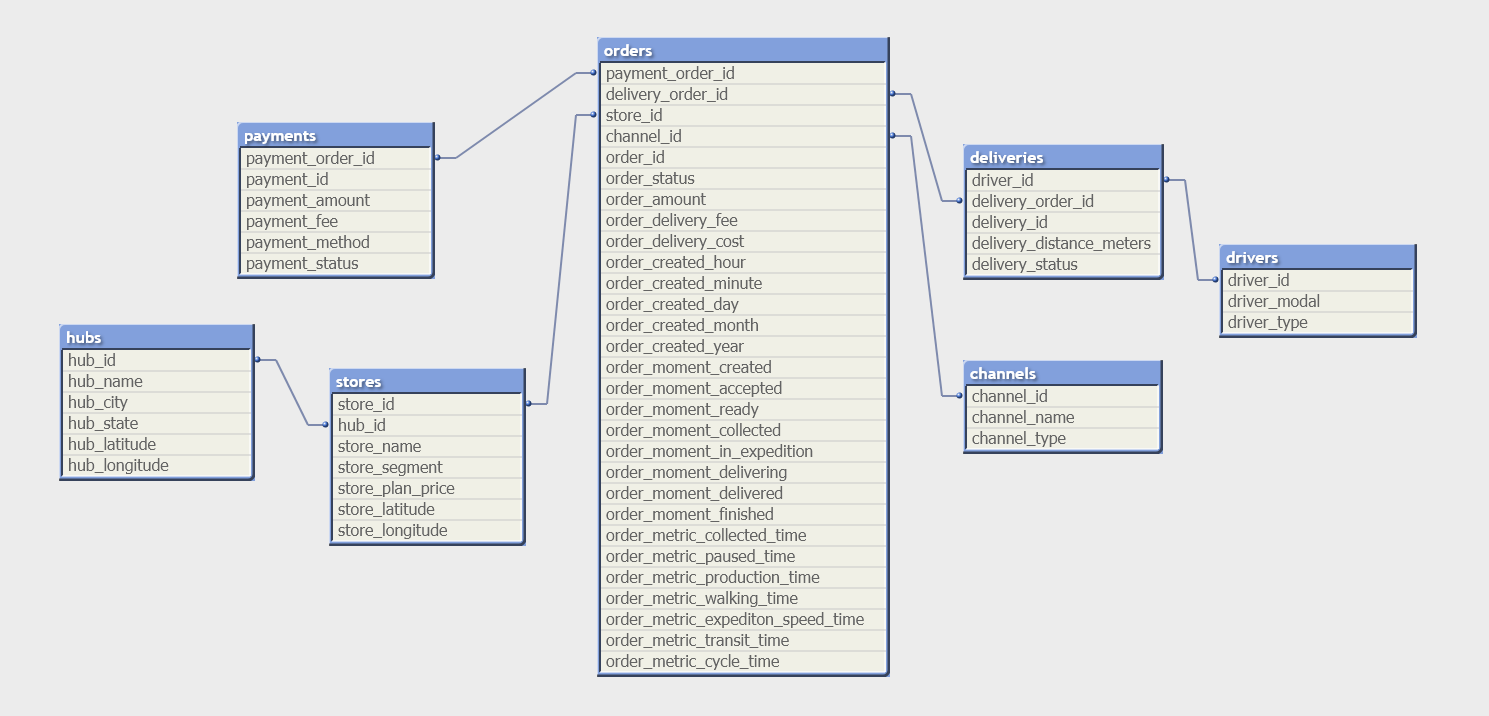

In [7]:
# lendo
canais = pd.read_csv('channels.csv')
entregas = pd.read_csv('deliveries.csv')
driver = pd.read_csv('drivers.csv')
hub = pd.read_csv('hubs.csv', encoding = "ISO-8859-1")
df = pd.read_csv('orders.csv')
pay = pd.read_csv('payments.csv')
store = pd.read_csv('stores.csv', encoding = "ISO-8859-1")


# jutando informações de canais de compra
df = join(df, canais, 'channel_id')

# juntando entregas e motoristas
entregas = join(entregas, driver, 'driver_id')
entregas = entregas.dropna()
df = join(df, entregas, 'delivery_order_id')

#  lojas e hubs.
store = join(store, hub, 'hub_id')
df = join(df, store, 'store_id')

# payments
df = join(df, pay, 'payment_order_id')


# dropando colunas com MUITOS nulos, e que não tenham uma descrição que aparente relação com o y do projeto
df = df.drop([
            'order_moment_ready',
            'order_moment_collected',
            'order_moment_in_expedition',
            'order_moment_delivering',
            'order_moment_delivered',
            'order_metric_collected_time',
            'order_metric_paused_time',
            'order_metric_expediton_speed_time',
            'order_metric_walking_time',
            'order_metric_production_time',
            'order_metric_transit_time',
             'order_metric_cycle_time']
            , axis=1)


# mantendo apenas ordens que foram entregues
df = df.loc[df['order_status'] == 'FINISHED']


## Cleaning Data

### order_delivery_cost
Se trata do preço do frete, vamo fazer um "treino e teste", observando o erro obtido se usarmos a média do preço, não acredito que nulo seja 0, pois o valor 0 exite na coluna quando o frete é gratuito.

In [8]:
# instaciando x e y
x = df.dropna()
y = x['order_delivery_cost']
x = x.drop('order_delivery_cost', axis=1)

xtr, xval, ytr, yval = train_test_split(x, y, test_size = 0.33)

# preenchendo p com média

p = xval
p['payment_status'] = np.mean(y)
p = p['payment_status']

mean_absolute_error(p, yval) # erro não tão alto

2.211557244318398

In [9]:
df.loc[df['order_delivery_cost'].isnull(), 'order_delivery_cost'] = np.mean(df['order_delivery_cost'])

###  order_moment_accepted

momento em que a ordem foi aceita, geralmente é colado com o momento em que foi criada, como tenho apenas 1653 registros nessa situação irei tira-los dos dados. assim toda ordem criada no dataset tera sua devida data de aceite.

In [10]:
df = df.loc[df['order_moment_accepted'].notnull()]

### delivery_id

É apenas um identificador da entrega, quando esse valor é nulo outros colunas também são, vamos analisar todas juntas

In [11]:
df['order_moment_created'].loc[df['delivery_id'].isnull()]

# não necessesariamente os valores são recentes, não está nulo por falta de entrega

299         1/1/2021 4:31:59 PM
314         1/1/2021 4:35:54 PM
323         1/1/2021 4:38:22 PM
353         1/1/2021 4:57:34 PM
604         1/1/2021 6:33:55 PM
                  ...          
440585    4/30/2021 11:43:20 PM
440694    4/30/2021 11:51:21 PM
440695    4/30/2021 11:51:21 PM
440716    4/30/2021 11:53:12 PM
440775    4/30/2021 11:59:32 PM
Name: order_moment_created, Length: 10033, dtype: object

In [12]:
df[['delivery_id',
    'delivery_distance_meters',
    'delivery_status',
    'driver_modal',
    'driver_type']].loc[df['delivery_id'].isnull()]

,delivery_id,delivery_distance_meters,delivery_status,driver_modal,driver_type
299,NaN,NaN,NaN,NaN,NaN
314,NaN,NaN,NaN,NaN,NaN
323,NaN,NaN,NaN,NaN,NaN
353,NaN,NaN,NaN,NaN,NaN
604,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
440585,NaN,NaN,NaN,NaN,NaN
440694,NaN,NaN,NaN,NaN,NaN
440695,NaN,NaN,NaN,NaN,NaN
440716,NaN,NaN,NaN,NaN,NaN


Quando essa coluna é nula os muitos outros valores nulos acompanham, vou retirar esses registros pois:

* São apenas 10mil linhas.
* Os valores são nulos em mais de uma coluna, quando essa coluna é nula, oque além de dificultar o preenchiemento, mostra que esses valores não são confiáveis.

In [13]:
df = df.loc[df['delivery_id'].notnull()]

### store_plan_price

Se trata do valor do plano que a loja paga para a delivery's center, há 96mil valores nulos, preciso tentar preencher isso de alguma maneira.

Notei que muitas lojas com valores nulosde plano tem seu nome com o valor não nulo em outro momento do dataframe, optei por prenhcer nulos com os valores mais rentes que aquela loja apareceu pagando no dataset!

In [14]:
df['store_name']

8         LILI CISRUMACS 
9         LILI CISRUMACS 
18               IUMPICA 
19               IUMPICA 
20          EAVAMI FIGOI 
               ...       
440774        CICI PIRPU 
440776           IUMPICA 
440777           IUMPICA 
440778           IUMPICA 
440779           IUMPICA 
Name: store_name, Length: 411865, dtype: object

In [15]:
df['store_plan_price'].value_counts()

49.90    124120
0.00      99055
49.00     53406
29.90     19210
29.00     18022
0.01       6600
1.00        210
29.29       184
19.90        10
39.00         2
Name: store_plan_price, dtype: int64

In [16]:
df = df.sort_values(['store_name', 'order_moment_created'])

for i in range(len(df)):
    if pd.isnull(df['store_plan_price'].iloc[i]) == True:
        df['store_plan_price'].iloc[i] = df['store_plan_price'].iloc[i -1]

C:\Users\Pedro\anaconda3\envs\DeliveryCenter\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
df = df.sort_values('order_moment_created')

### resto das colunas
Apenas 2982/400mil linhas ainda eram nulas, como mais nenhuma coluna além dessas apresenta grande quantia de nulos, irei trabalhar sem esses valores!

In [18]:
df = df.dropna()

In [19]:
# 409mil linhas para trabalhar

len(df)

408992

## Tipando os dados

tipos pra mudar:

* order_id : object
* delivery_id: object
* payment_id: object
* order_momment_created: data
* order_moment_accepted: data
* order_moment_finished : data

In [20]:
# tipando tudo de uma vez

# object's
df['order_id'] = df['order_id'].astype(str)
df['delivery_id'] = df['delivery_id'].astype(str)
df['payment_id'] = df['payment_id'].astype(str)

# datas
df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
df['order_moment_accepted'] = pd.to_datetime(df['order_moment_accepted'])
df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

In [21]:
# sorting
df = df[['store_name','order_id', 'order_amount', 'order_moment_created', 
       'order_moment_accepted', 'order_moment_finished', 'order_delivery_fee', 
       'order_delivery_cost','order_created_hour', 'order_created_minute',
       'order_created_day', 'order_created_month', 'order_created_year',
       'channel_name', 'channel_type', 'delivery_id','driver_modal',
       'delivery_distance_meters', 'delivery_status', 
       'driver_type', 'store_segment', 'store_plan_price',
       'hub_name', 'hub_city', 'hub_state',  'payment_id', 'order_status',
       'payment_amount', 'payment_fee', 'payment_method', 'payment_status', 
       'hub_latitude', 'hub_longitude','store_latitude', 'store_longitude']]

In [22]:
# tirando .0 do final dos id's

df['order_id'] = pd.Series(map(lambda x: x[:-2], df['order_id']))
df['delivery_id'] = pd.Series(map(lambda x: x[:-2], df['delivery_id']))
df['payment_id'] = pd.Series(map(lambda x: x[:-2], df['payment_id']))

## Mapa de Hipóteses

Aqui são elencados as coisas que afetam o fênomeno de vendas das lojas, buscando uma forma de crirar novas variáveis e dar um direcionamento para a próxima fase, a EDA!

        ** fazer depois **

Tive muitas ideias relacionadas a KPI'S! Acredito que um algorítimo que saiba os kpi's de uma loja no momento que está prevendo as vendas da semana quem vem possa ter um alto acerto em suas previsões:

Features para criar (sempre se atentando em NÃO pegar dados do futuro pra montar kpi's que estão no passado):

## Transformando Dataset em Dataset para time Series Diária

Agregando as vendas por semana

In [24]:
# copia por via das duvidas
dfaux = df.copy()
dfaux = dfaux.sort_values('order_moment_finished')

# fazendo label de dia
dfaux = day_making(dfaux, 'order_moment_finished')

# instanciando como 'df' novamente
df = dfaux.copy()

# salvando
df.to_csv('Formatação&FeatureEngineringemSQL.csv', index=[0])

C:\Users\Pedro\anaconda3\envs\DeliveryCenter\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


    %sql

    SELECT
      store_name,
      hub_city AS city,
      hub_state AS state,

      LEFT(
      DATE_TRUNC('day', order_moment_finished)
      , 10) AS date,

      store_segment,
      store_latitude, 
      store_longitude,

      ROUND(SUM(order_amount) ,2) AS sales,
      COUNT(order_id) AS pedidos,
      ROUND(AVG(order_amount) ,2) AS avg_ticket


    FROM `Formatacao`
    GROUP BY DATE_TRUNC('day', order_moment_finished), store_name,  city, state, store_segment, store_latitude, store_longitude
    ORDER BY date

In [116]:
df_of = pd.read_csv('export.csv').sort_values(['store_name','city','store_segment','store_latitude','store_longitude','date'])

In [117]:
df_of = pd.DataFrame()

for i in range(len(dfaux)):
    if i == len(dfaux) and dfaux['store_name'].iloc[i] == dfaux['store_name'].iloc[i-1]:
        df_store = dfaux.loc[
                            (dfaux['store_name'] == dfaux['store_name'].iloc[i]) &
                            (dfaux['city'] == dfaux['city'].iloc[i]) &
                            (dfaux['store_segment'] == dfaux['store_segment'].iloc[i]) &
                            (dfaux['store_latitude'] == dfaux['store_latitude'].iloc[i]) &
                            (dfaux['store_longitude'] == dfaux['store_longitude'].iloc[i])
                            ].sort_values('date')
        if len(df_store) > 29:
            df_store = generate_supervised(df_store)
            df_of = pd.concat([df_of, df_store], ignore_index=True)
            break
            
    elif i == len(dfaux):
        break
   
    elif i != len(dfaux):
        if dfaux['store_name'].iloc[i] == dfaux['store_name'].iloc[i-1] and dfaux['store_name'].iloc[i] != dfaux['store_name'].iloc[i+1]:
            df_store = dfaux.loc[
                        (dfaux['store_name'] == dfaux['store_name'].iloc[i]) &
                        (dfaux['city'] == dfaux['city'].iloc[i]) &
                        (dfaux['store_segment'] == dfaux['store_segment'].iloc[i]) &
                        (dfaux['store_latitude'] == dfaux['store_latitude'].iloc[i]) &
                        (dfaux['store_longitude'] == dfaux['store_longitude'].iloc[i])
                        ].sort_values('date')
            if len(df_store) > 29:
                df_store = generate_supervised(df_store)
                df_of = pd.concat([df_of, df_store], ignore_index=True)

IndexError: single positional indexer is out-of-bounds

In [118]:
df_of['y'] = -999
df_of = df_of.sort_values(['store_name','city','store_segment','store_latitude','store_longitude','date'])

for i in range(len(df_of)):
    
    if df_of['store_name'].iloc[i] == df_of['store_name'].iloc[i+1] and df_of['city'].iloc[i] == df_of['city'].iloc[i+1] and df_of['store_segment'].iloc[i] == df_of['store_segment'].iloc[+1] and df_of['store_latitude'].iloc[i] == df_of['store_latitude'].iloc[i+1] and df_of['store_longitude'].iloc[i] == df_of['store_longitude'].iloc[i+1]:
    
        df_of['y'].iloc[i] = df_of['sales'].iloc[i+1]
        
df_of = df_of.loc[df_of['y'] != -999]

C:\Users\Pedro\anaconda3\envs\DeliveryCenter\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


IndexError: single positional indexer is out-of-bounds

In [119]:
df_of.to_csv('time_ready.csv', index=False)

## Feature Enginering

In [120]:
df = pd.read_csv('time_ready.csv')
df = df.set_index('index')

In [121]:
df.sample()

,store_name,city,state,date,store_segment,store_latitude,store_longitude,sales,pedidos,avg_ticket,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,y
index,,,,,,,,,,,,,,,,,,,,,
12645,AR TRAMUO,SÃO PAULO,SP,2021-02-25,FOOD,-23.561053,-46.558976,328.5,8,41.06,...,273.7,315.9,93.2,188.6,364.1,85.4,237.5,283.3,181.3,751.9
